In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calibration_08302023 as cal
import sys
sys.path.append('../../')
from utils import *
from fears.utils import AutoRate
import pickle

spline_path = '../calibration_code/spline_cal_01312024.pkl'
spline = pickle.load(open(spline_path,'rb'))

rfu30_to_dilution = cal.run()

data_file = '../experiment_data/DNase_exp_01312024.xlsx'

ab_folder = '../experiment_data/DNase_exp_ab_01312024'

df = pd.read_excel(data_file, header=0)
df['Cell count 10^4'] = df['Cell count 10^4']*10**4/50
df['Cell count 10^5'] = df['Cell count 10^5']*10**5/50
df['Cell count 10^6'] = df['Cell count 10^6']*10**6/50

df['mean'] = df[['Cell count 10^4','Cell count 10^5','Cell count 10^6']].mean(axis=1)

In [2]:
files = os.listdir(ab_folder)
files = [f for f in files if f.endswith('.xlsx')
         and not f.startswith('.')]
files.sort(key=natural_keys)

replicates = ['D','E','F']

cols = ['2','3']

rfu_dict = {'mean':[],
            'err':[]}
cell_count_dict = {'mean':[],
                   'err':[],
                   'log_mean':[],
                   'log_err':[]}

cell_count_raw = {}

time_list = []

for i,col in enumerate(cols):
    file = files[i]
    file_path = os.path.join(ab_folder,file)
    p = AutoRate.Plate(file_path,mode='single_measurement')
    data = p.od_data_to_dict(p.data)

    time_list.append(p.get_start_time())

    rfu_t = []
    for row in replicates:
        key = row+col
        rfu_t.append(data[key]/7800)
    
    # cell_count_t = rfu30_to_dilution(rfu_t,background_subtractedc=False)

    cell_count_t = spline(rfu_t)*137928
    cell_count_log = np.log10(cell_count_t)

    rfu_dict['mean'].append(np.mean(rfu_t))
    rfu_dict['err'].append(np.std(rfu_t)/np.sqrt(len(rfu_t)))
    cell_count_dict['mean'].append(np.mean(cell_count_t))
    cell_count_dict['err'].append(np.std(cell_count_t)/np.sqrt(len(cell_count_t)))
    cell_count_dict['log_mean'].append(np.mean(cell_count_log))
    cell_count_dict['log_err'].append(np.std(cell_count_log)/np.sqrt(len(cell_count_log)))

    cell_count_raw[i] = cell_count_t

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time = np.array(time)

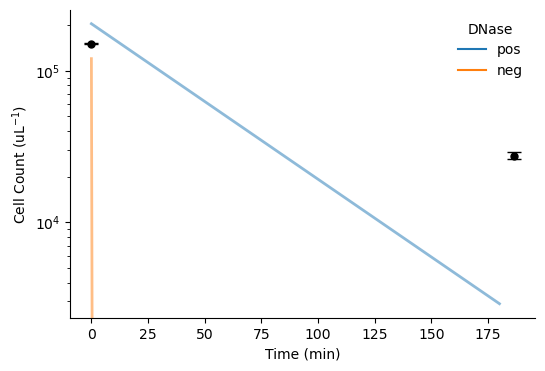

In [3]:
fig,ax = plt.subplots(figsize=(6,4))

s = 40

# ax = sns.scatterplot(y='Cell count 10^4', x='Time', data=df, hue='DNase', legend=True, ax=ax,s=s)
# ax = sns.scatterplot(y='Cell count 10^5', x='Time', data=df, hue='DNase', legend=True, ax=ax,s=s)

ax = sns.lineplot(y='mean', x='Time', data=df, hue='DNase', ax=ax, alpha=0.5,linewidth=2)

# ax.set_yscale('log')

# only plot unique legend entries

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), frameon=False,title='DNase')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Time (min)')
ax.set_ylabel('Cell Count (uL$^{-1}$)')

ax.errorbar(time,cell_count_dict['mean'],yerr=cell_count_dict['err'],fmt='o',color='k',capsize=5,markersize=5)

ax.set_yscale('log')


(-10.0, 1000000.0)

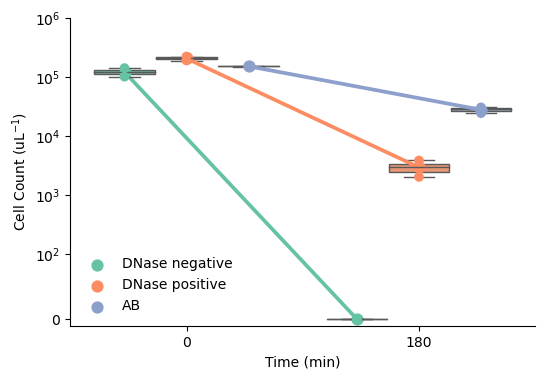

In [4]:
data_file = '../experiment_data/DNase_exp_01312024_long.xlsx'

df = pd.read_excel(data_file, header=0)

fig,ax = plt.subplots(figsize=(6,4))

s = 7

hue_order = ['neg','pos','AB']

ax = sns.stripplot(x='Time', y='Cell count', data=df, hue='DNase', ax=ax,
                   dodge=True,jitter=False,palette='Set2',s=s,hue_order=hue_order)

ax = sns.boxplot(x='Time', y='Cell count', data=df, hue='DNase', ax=ax,
                 palette='Set2',hue_order=hue_order,linewidth=1)  

ax.set_yscale('symlog',linthresh=100)


sns.pointplot(x='Time', y='Cell count', data=df, hue='DNase', hue_order=hue_order, ax=ax,
              dodge=.8 - .8 / 3, marker='',linewidth=2,palette='Set2')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), ['DNase negative','DNase positive','AB'], frameon=False,loc='lower left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Time (min)')
ax.set_ylabel('Cell Count (uL$^{-1}$)')

ax.set_ylim(-10,10**6)

In [5]:
fig.savefig('DNase_exp_01312024.pdf',bbox_inches='tight')